### Credit for code: https://www.kaggle.com/grapestone5321/ashrae-stacking-method
### Credit for method: https://mlwave.com/kaggle-ensembling-guide/

In [1]:
#Python packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)
import re
from scipy import stats

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ML modeling packages
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
import gc

from scipy.stats.mstats import gmean

In [2]:
train = pd.read_pickle('test_mod3.pkl')

In [5]:
cols = ['2_fold', '5_fold', 'meter_fold']
concat_sub = train[cols]

In [6]:
concat_sub['row_id'] = range(0,len(concat_sub))

In [7]:
cols = ['row_id','2_fold', '5_fold', 'meter_fold']
concat_sub = concat_sub[cols]
concat_sub.head()

,row_id,2_fold,5_fold,meter_fold
0,0,91.977791,133.952240,195.486406
1,1,54.447552,27.905941,96.063122
2,2,11.434571,8.312962,10.871022
3,3,129.405502,239.048706,306.991885
4,4,465.785004,910.702881,1305.281864


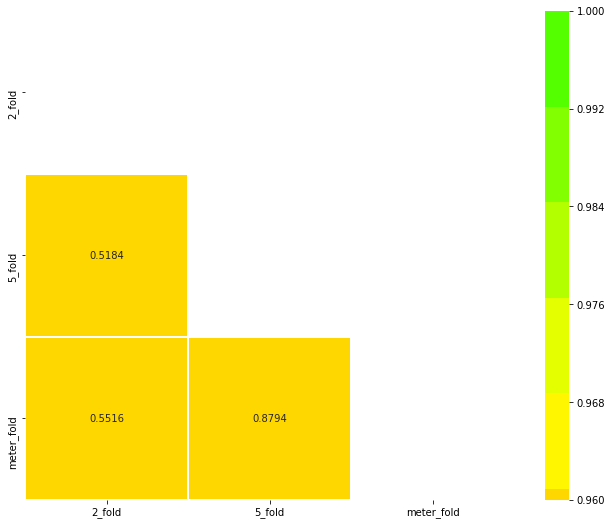

In [17]:
corr = concat_sub.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='prism', vmin=0.96, center=0, square=True, linewidths=1, annot=True, fmt='.4f')

In [8]:
concat_sub['m_max'] = concat_sub.iloc[:, 1:].max(axis=1)
concat_sub['m_min'] = concat_sub.iloc[:, 1:].min(axis=1)
concat_sub['m_median'] = concat_sub.iloc[:, 1:].median(axis=1)

In [9]:
cutoff_lo = 0.8
cutoff_hi = 0.2

In [10]:
ncol = concat_sub.shape[1]

rank = np.tril(concat_sub.iloc[:,1:ncol].corr().values,-1)
m_gmean = 0
n = 8
while rank.max()>0:
    mx = np.unravel_index(rank.argmax(), rank.shape)
    m_gmean += n*(np.log(concat_sub.iloc[:, mx[0]+1]) + np.log(concat_sub.iloc[:, mx[1]+1]))/2
    rank[mx] = 0
    n += 1

In [11]:
concat_sub['m_mean'] = np.exp(m_gmean/(n-1)**2)

In [12]:
concat_sub['meter_reading'] = concat_sub['m_mean']
concat_sub[['row_id', 'meter_reading']].to_csv('stack_mean.csv', 
                                        index=False, float_format='%.6f')

In [13]:
concat_sub['meter_reading'] = concat_sub['m_median']
concat_sub[['row_id', 'meter_reading']].to_csv('stack_median.csv', 
                                        index=False, float_format='%.6f')

In [14]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 1, 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             0, concat_sub['m_median']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_pushout_median.csv', 
                                        index=False, float_format='%.6f')

In [15]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_mean']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_minmax_mean.csv', 
                                        index=False, float_format='%.6f')

In [16]:
concat_sub['meter_reading'] = np.where(np.all(concat_sub.iloc[:,1:7] > cutoff_lo, axis=1), 
                                    concat_sub['m_max'], 
                                    np.where(np.all(concat_sub.iloc[:,1:7] < cutoff_hi, axis=1),
                                             concat_sub['m_min'], 
                                             concat_sub['m_median']))
concat_sub[['row_id', 'meter_reading']].to_csv('stack_minmax_median.csv', 
                                        index=False, float_format='%.6f')

In [17]:
concat_sub['meter_reading'] = concat_sub['2_fold'].rank(method ='min') + concat_sub['5_fold'].rank(method ='min') + concat_sub['meter_fold'].rank(method ='min') 
concat_sub['meter_reading'] = (concat_sub['meter_reading']-concat_sub['meter_reading'].min())/(concat_sub['meter_reading'].max() - concat_sub['meter_reading'].min())
concat_sub.describe()
concat_sub[['row_id', 'meter_reading']].to_csv('stack_rank.csv', index=False, float_format='%.8f')


### Ensembling CSV's for final model

In [3]:
stack_mean = pd.read_csv('stack_mean.csv', index_col=0)
stack_median = pd.read_csv('stack_median.csv', index_col=0)
stack_pushout = pd.read_csv('stack_pushout_median.csv', index_col=0)
stack_minmax_mean = pd.read_csv('stack_minmax_mean.csv', index_col=0)
stack_minmax_median = pd.read_csv('stack_minmax_median.csv', index_col=0)
stack_rank = pd.read_csv('stack_rank.csv', index_col=0)

In [4]:
ultimate_stack = pd.DataFrame({'mean':stack_mean['meter_reading'], 'median':stack_median['meter_reading'],
                              'pushout':stack_pushout['meter_reading'], 'minmax_mean':stack_minmax_mean['meter_reading'],
                              'minmax_median':stack_minmax_median['meter_reading'], 'rank':stack_rank['meter_reading']})
ultimate_stack.head()

,mean,median,pushout,minmax_mean,minmax_median,rank
row_id,,,,,,
0,9.709787,133.952240,1.0,195.486406,195.486406,0.672447
1,6.187114,54.447552,1.0,96.063122,96.063122,0.451801
2,2.914082,10.871022,1.0,11.434571,11.434571,0.161430
3,12.034784,239.048706,1.0,306.991885,306.991885,0.761627
4,22.568812,910.702881,1.0,1305.281864,1305.281864,0.930101


In [5]:
folds = ['2_fold', '5_fold', 'meter_fold']
models = train[folds]
models.head()

,2_fold,5_fold,meter_fold
0,91.977791,133.952240,195.486406
1,54.447552,27.905941,96.063122
2,11.434571,8.312962,10.871022
3,129.405502,239.048706,306.991885
4,465.785004,910.702881,1305.281864


In [6]:
models['2_fold_rank'] = models['2_fold'].rank(method='max')
models['2_fold_rank'] = (models['2_fold_rank']-models['2_fold_rank'].min()
                        )/(models['2_fold_rank'].max() - models['2_fold_rank'].min())
models['min_max_rank'] = ultimate_stack['minmax_mean'].rank(method='max')
models['min_max_rank'] = (models['min_max_rank']-models['min_max_rank'].min()
                        )/(models['min_max_rank'].max() - models['min_max_rank'].min())
models['rank'] = ultimate_stack['rank']
models['minmax_mean'] = ultimate_stack['minmax_mean']
models['median_rank'] = ultimate_stack['median'].rank(method='max')
models['median_rank'] = (models['median_rank']-models['median_rank'].min()
                        )/(models['median_rank'].max() - models['median_rank'].min())

In [7]:
models['median'] = ultimate_stack['median']
models['gmean'] = gmean([models['2_fold'], models['2_fold'],models['5_fold'], models['meter_fold']])

In [8]:
models['gmean_rank'] = models['gmean'].rank(method='max')
models['gmean_rank'] = (models['gmean_rank']-models['gmean_rank'].min()
                        )/(models['gmean_rank'].max() - models['gmean_rank'].min())

In [9]:
models.shape

(41697600, 11)

In [10]:
models.loc[(abs(models['2_fold_rank'] - models['gmean_rank'])<abs(models['2_fold_rank']-models['median_rank'])),
           'final_reading'] = ((models['gmean'])*.4)+((models['2_fold'])*.45)+(models['median']*.15)
models.loc[(abs(models['2_fold_rank'] - models['gmean_rank'])>abs(models['2_fold_rank']-models['median_rank'])),
           'final_reading'] =((models['gmean'])*.15)+((models['2_fold'])*.45)+(models['median']*.4)

In [11]:
final_df = pd.DataFrame({'row_id':range(len(train)), 'meter_reading':models['final_reading']})
final_df.head()

,row_id,meter_reading
0,0,110.282650
1,1,54.244649
2,2,11.057861
3,3,168.982516
4,4,631.259964


In [12]:
final_df.to_csv('submission.csv', index=False)

In [2]:
final = pd.read_csv('submission.csv', index_col=0)

In [5]:
final.head()

,meter_reading
row_id,
0,174.784683
1,62.770666
2,11.434571
3,271.474608
4,1137.382492


In [7]:
results_df = pd.DataFrame({"row_id": range(0,len(test)), "meter_reading": final['meter_reading']})
results_df.head()

,row_id,meter_reading
row_id,,
0,0,174.784683
1,1,62.770666
2,2,11.434571
3,3,271.474608
4,4,1137.382492


In [13]:
results_df.loc[results_df['meter_reading']<0, 'meter_reading'] = abs(results_df['meter_reading'])
results_df.loc[results_df['meter_reading'].isna(), 'meter_reading'] = abs(test['2_fold'])

In [18]:
# results_df.reset_index(inplace=True)
results_df.drop('row_id', axis=1, inplace=True)

In [20]:
results_df.reset_index(inplace=True)
results_df.head()

,row_id,meter_reading
0,0,174.784683
1,1,62.770666
2,2,11.434571
3,3,271.474608
4,4,1137.382492


In [21]:
results_df.to_csv('submission.csv', index=False)